# T09 - Resampling

### 1. Usando propiedades básicas de la varianza y cálculo de una variable, derive la ecuación (5.6)

Sea

$$
Z(\alpha) = \alpha X + (1-\alpha)Y.
$$

Usando la bilinealidad de la varianza y la covarianza:

$$
\operatorname{Var}(Z(\alpha)) 
= \alpha^{2}\operatorname{Var}(X)
+ (1-\alpha)^{2}\operatorname{Var}(Y)
+ 2\alpha(1-\alpha)\operatorname{Cov}(X,Y).
$$

Ahora derivamos respecto a alpha:

$$
V'(\alpha)
= 2\alpha\sigma_X^{2}
- 2(1-\alpha)\sigma_Y^{2}
+ 2(1-2\alpha)\sigma_{XY}.
$$

Igualamos a cero para encontrar el mínimo:

$$
2\alpha\sigma_X^{2}
- 2(1-\alpha)\sigma_Y^{2}
+ 2(1-2\alpha)\sigma_{XY} = 0.
$$

Dividiendo entre 2:

$$
\alpha\sigma_X^{2}
- (1-\alpha)\sigma_Y^{2}
+ (1-2\alpha)\sigma_{XY} = 0.
$$

Reordenamos términos:

$$
\alpha(\sigma_X^{2} + \sigma_Y^{2} - 2\sigma_{XY})
= \sigma_Y^{2} - \sigma_{XY}.
$$

Por tanto, la alpha que minimiza la varianza es

$$
\boxed{
\alpha =
\frac{\sigma_Y^{2} - \sigma_{XY}}
{\sigma_X^{2} + \sigma_Y^{2} - 2\sigma_{XY}}
}
$$

Finalmente, verificamos que la segunda derivada es positiva:

$$
V''(\alpha) = 2\sigma_X^{2} + 2\sigma_Y^{2} - 4\sigma_{XY} > 0,
$$

lo que confirma que este valor de alpha minimiza \(\operatorname{Var}(Z(\alpha))\).


### 2. Probabilidad de que una observación aparezca en una muestra bootstrap

En cada selección del bootstrap se elige una observación al azar, con **reemplazo**, entre las \(n\) observaciones originales.  
Por lo tanto, la probabilidad de que la observación \(j\) sea tomada en un intento es:

$$
\frac{1}{n}
$$

y la probabilidad de **no** elegirla es:

$$
1 - \frac{1}{n}.
$$

Como en una muestra bootstrap se realizan \(n\) elecciones independientes, la probabilidad de que la observación \(j\) **nunca** sea seleccionada es:

$$
\left(1 - \frac{1}{n}\right)^n.
$$

Por lo tanto, la probabilidad de que **sí** aparezca al menos una vez en la muestra bootstrap es:

$$
1 - \left(1 - \frac{1}{n}\right)^n.
$$

---

### Ejemplos

- **\(n = 5\):**
  $$
  1 - (1 - 1/5)^5 = 1 - 0.8^5 \approx 0.6723
  $$

- **\(n = 100\):**
  $$
  1 - (1 - 1/100)^{100} \approx 0.63397
  $$

- **\(n = 10\,000\):**
  $$
  1 - (1 - 1/10000)^{10000} \approx 0.63212
  $$

---

### Comentario importante

Cuando \( n \to \infty \), se cumple el límite conocido:

$$
\left(1 - \frac{1}{n}\right)^n \to e^{-1}.
$$

Por tanto, la probabilidad límite de que una observación cualquiera aparezca en una muestra bootstrap es:

$$
1 - e^{-1} \approx 0.6321.
$$

Es decir, en promedio, un bootstrap contiene aproximadamente el **63.2%** de las observaciones originales (al menos una vez), mientras que el resto queda fuera.


In [121]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split, KFold, cross_val_score, LeaveOneOut
from sklearn.metrics import mean_squared_error, accuracy_score
import statsmodels.api as sm

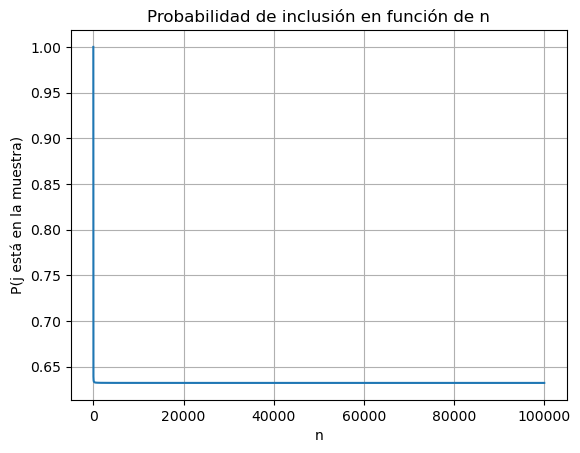

In [123]:
n_values = np.arange(1, 100001)
probabilities = 1 - ((n_values - 1) / n_values) ** n_values

plt.plot(n_values, probabilities)
plt.xlabel('n')
plt.ylabel('P(j está en la muestra)')
plt.title('Probabilidad de inclusión en función de n')
plt.grid(True)

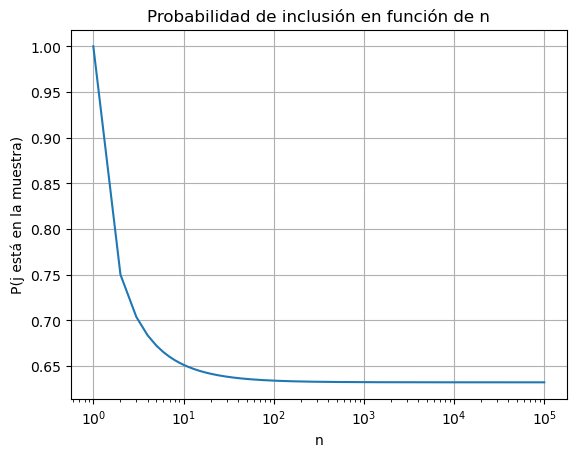

In [125]:
n_values = np.arange(1, 100001)
probabilities = 1 - ((n_values - 1) / n_values) ** n_values
plt.plot(n_values, probabilities)
plt.xlabel('n')
plt.ylabel('P(j está en la muestra)')
plt.title('Probabilidad de inclusión en función de n')
plt.grid(True)


plt.xscale('log')

El gráfico indica que la probabilidad de que la observación j esté incluida en la muestra bootstrap crece de forma acelerada al inicio y luego se aproxima al valor límite cercano a 0.632.
Con la escala logarítmica se distingue con mayor claridad cómo la curva varía para valores pequeños de n antes de volverse prácticamente constante.

In [128]:
n = 100       
j = 4         
trials = 10000
store = np.zeros(trials)
for t in range(trials):
    sample = np.random.choice(np.arange(n), size=n, replace=True)
    store[t] = (j in sample)   

In [130]:
store.mean()

0.6273

In [132]:
rng = np.random.default_rng(10)
store = np.zeros(10000)

for i in range(10000):
    store[i] = (np.sum(rng.choice(100, size=100, replace=True) == 4) > 0)

In [133]:
np.mean(store)

0.6362

0.6376 y 0.6362 se acercan mucho a 0.6321. Las diferencias se deben a la los datos aleatorios. 

### 3. K-fold cross-validation

**¿Cómo funciona?**  
El método consiste en partir el conjunto de datos en **k bloques del mismo tamaño**. Luego, se ejecutan **k ciclos** donde, en cada uno, un bloque se usa como prueba y los otros **k−1** sirven para entrenar el modelo. Al final, se promedian los errores obtenidos en cada iteración para obtener una medida más confiable del desempeño.

#### i. Comparado con *validation set*
- **Ventaja:** produce una evaluación más estable, ya que utiliza varias particiones y permite entrenar el modelo en mayor cantidad de datos.  
- **Desventaja:** implica más tiempo de cómputo, porque el modelo debe ajustarse k veces.

#### ii. Comparado con LOOCV
- **Ventaja:** es considerablemente más rápido y suele presentar menor variabilidad que LOOCV.  
- **Desventaja:** puede ser un poco menos exacto que LOOCV, ya que cada entrenamiento se hace con menos datos que en el caso extremo de usar n−1 observaciones.

---

### 4. Estimar la desviación estándar de una predicción

La incertidumbre de una predicción puede aproximarse mediante el **bootstrap**, que nos permite ver qué tanto cambia el modelo al modificar los datos. El proceso se puede resumir así:

1. Generar múltiples muestras bootstrap a partir de los datos originales, seleccionando con reemplazo.  
2. Ajustar el mismo modelo en cada una de esas muestras generadas.  
3. Obtener la predicción para el mismo valor de \(X\) en todas las réplicas del modelo.  
4. Calcular la **desviación estándar** de esas predicciones.

La dispersión entre las predicciones obtenidas a través de las muestras bootstrap nos ofrece una idea clara de la variabilidad de la predicción original.


### 5. Problemas de aplicación

In [139]:
!pip install ISLP

In [37]:
pip install --upgrade pip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 9.0 MB/s  0:00:00m eta 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 25.2
    Uninstalling pip-25.2:
      Successfully uninstalled pip-25.2
Note: you may need to restart the kernel to use updated packages.


In [141]:
from sklearn.utils import resample
from ISLP import load_data

In [143]:
# A)
default = load_data('Default')
default["default"] = (default["default"] == "Yes").astype(int)
default = default.drop(columns=["student"])

x = default.drop(columns=["default"])
y = default["default"]

model_initial = sm.Logit(y, sm.add_constant(x)).fit()
model_initial.summary()

Optimization terminated successfully.
         Current function value: 0.078948
         Iterations 10


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                default   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9997
Method:                           MLE   Df Model:                            2
Date:                Fri, 28 Nov 2025   Pseudo R-squ.:                  0.4594
Time:                        17:37:00   Log-Likelihood:                -789.48
converged:                       True   LL-Null:                       -1460.3
Covariance Type:            nonrobust   LLR p-value:                4.541e-292
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -11.5405      0.435    -26.544      0.000     -12.393     -10.688
balance        0.0056      0.000     24.835      0.000       0.005       0.006
income      2.081e-05   4.99e-06      4.174      0.000     1.1e-05    3.06e-05
==============================================================================

Possibly complete quasi-separation: A fraction 0.14 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

El modelo logístico se ajustó sin problemas. Los resultados muestran que balance es la variable que más influye en predecir default: su coeficiente es positivo y muy significativo.
La variable income también tiene efecto, pero es mucho más pequeño.

El Pseudo R^2 = 0.46 sugiere que el modelo logra un buen nivel de explicación.
El mensaje de “quasi-separation” es normal en este conjunto de datos y solo indica que algunas observaciones se clasifican casi perfectamente. Esto no afecta lo que necesitamos analizar en este ejercicio.

In [146]:
#B)

train, test = train_test_split(default, test_size=0.3, random_state=42)
x_train = train.drop(columns=["default"])
y_train = train["default"]
x_test = test.drop(columns=["default"])
y_test = test["default"]
model_default = sm.Logit(y_train, sm.add_constant(x_train)).fit()
model_default.summary()

Optimization terminated successfully.
         Current function value: 0.078256
         Iterations 10


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                default   No. Observations:                 7000
Model:                          Logit   Df Residuals:                     6997
Method:                           MLE   Df Model:                            2
Date:                Fri, 28 Nov 2025   Pseudo R-squ.:                  0.4743
Time:                        17:37:02   Log-Likelihood:                -547.79
converged:                       True   LL-Null:                       -1042.0
Covariance Type:            nonrobust   LLR p-value:                2.273e-215
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -11.6019      0.522    -22.236      0.000     -12.624     -10.579
balance        0.0057      0.000     20.976      0.000       0.005       0.006
income      1.872e-05   5.92e-06      3.163      0.002    7.12e-06    3.03e-05
==============================================================================

Possibly complete quasi-separation: A fraction 0.15 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

In [148]:
pred = model_default.predict(sm.add_constant(x_test))
pred_class = (pred >= 0.5).astype(int)
validation_error = np.mean(pred_class != y_test)
validation_error

0.02666666666666667

El modelo entrenado volvió a ajustarse sin dificultades. Los coeficientes muestran el mismo patrón que antes: balance sigue siendo la variable más importante, mientras que income influye pero en menor medida.
El mensaje de quasi-separation es común en este tipo de datos, así que no es un problema.

El error de validación fue cerca de 0.0267, lo que quiere decir que el modelo falló en aproximadamente 2.7% de los casos del conjunto de prueba. En general, esto indica que el modelo funciona bien y tiene buena capacidad para predecir nuevos datos.

In [151]:
#C
train, test = train_test_split(default, test_size=0.3, random_state=10)
x_train = train.drop(columns=["default"])
y_train = train["default"]
x_test = test.drop(columns=["default"])
y_test = test["default"]
model_default = sm.Logit(y_train, sm.add_constant(x_train)).fit()
pred = model_default.predict(sm.add_constant(x_test))
pred_class = (pred >= 0.5).astype(int)
validation_error = np.mean(pred_class != y_test)
validation_error

Optimization terminated successfully.
         Current function value: 0.074116
         Iterations 10


0.029666666666666668

In [153]:
train, test = train_test_split(default, test_size=0.3, random_state=5)
x_train = train.drop(columns=["default"])
y_train = train["default"]
x_test = test.drop(columns=["default"])
y_test = test["default"]
model_default = sm.Logit(y_train, sm.add_constant(x_train)).fit()
pred = model_default.predict(sm.add_constant(x_test))
pred_class = (pred >= 0.5).astype(int)
validation_error = np.mean(pred_class != y_test)
validation_error

Optimization terminated successfully.
         Current function value: 0.080827
         Iterations 10


0.025

In [155]:
train, test = train_test_split(default, test_size=0.3, random_state=123)
x_train = train.drop(columns=["default"])
y_train = train["default"]
x_test = test.drop(columns=["default"])
y_test = test["default"]
model_default = sm.Logit(y_train, sm.add_constant(x_train)).fit()
pred = model_default.predict(sm.add_constant(x_test))
pred_class = (pred >= 0.5).astype(int)
validation_error = np.mean(pred_class != y_test)
validation_error

Optimization terminated successfully.
         Current function value: 0.081061
         Iterations 10


0.025666666666666667

Los tres errores de validación resultaron casi iguales, todos entre 0.025 y 0.03. Esto significa que el método de validation set sí varía un poco dependiendo de cómo se dividen los datos, pero en este caso las diferencias fueron muy pequeñas. En general, el modelo tuvo un desempeño muy similar en las tres particiones.

In [158]:
#D)

default = load_data('Default')
default["default"] = (default["default"] == "Yes").astype(int)
default["student"] = (default["student"] == "Yes").astype(int)

train, test = train_test_split(default, test_size=0.3, random_state=42)
x_train = train.drop(columns=["default"])
y_train = train["default"]
x_test = test.drop(columns=["default"])
y_test = test["default"]
model_default = sm.Logit(y_train, sm.add_constant(x_train)).fit()
model_default.summary()

Optimization terminated successfully.
         Current function value: 0.078031
         Iterations 10


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                default   No. Observations:                 7000
Model:                          Logit   Df Residuals:                     6996
Method:                           MLE   Df Model:                            3
Date:                Fri, 28 Nov 2025   Pseudo R-squ.:                  0.4758
Time:                        17:37:04   Log-Likelihood:                -546.22
converged:                       True   LL-Null:                       -1042.0
Covariance Type:            nonrobust   LLR p-value:                1.189e-214
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -11.0709      0.595    -18.620      0.000     -12.236      -9.906
student       -0.5051      0.284     -1.780      0.075      -1.061       0.051
balance        0.0058      0.000     20.872      0.000       0.005       0.006
income      4.794e-06   9.83e-06      0.488      0.626   -1.45e-05    2.41e-05
==============================================================================

Possibly complete quasi-separation: A fraction 0.15 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

In [160]:
pred = model_default.predict(sm.add_constant(x_test))
pred_class = (pred >= 0.5).astype(int)
validation_error = np.mean(pred_class != y_test)
validation_error

0.02666666666666667

Al incluir la variable student, el modelo prácticamente no mejora. Su coeficiente no resulta significativo y el p-value es alto, lo que indica que no ayuda mucho a predecir default. Las variables balance e income siguen funcionando igual que antes, y balance continúa siendo la más importante por bastante. El validation error quedó casi igual al de los modelos anteriores, así que añadir student no cambia realmente el rendimiento del modelo.

### Problema 6.

In [164]:
#A)

model_logit = model_initial
model_logit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                default   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9997
Method:                           MLE   Df Model:                            2
Date:                Fri, 28 Nov 2025   Pseudo R-squ.:                  0.4594
Time:                        17:37:06   Log-Likelihood:                -789.48
converged:                       True   LL-Null:                       -1460.3
Covariance Type:            nonrobust   LLR p-value:                4.541e-292
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -11.5405      0.435    -26.544      0.000     -12.393     -10.688
balance        0.0056      0.000     24.835      0.000       0.005       0.006
income      2.081e-05   4.99e-06      4.174      0.000     1.1e-05    3.06e-05
==============================================================================

Possibly complete quasi-separation: A fraction 0.14 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

In [166]:
se_income = model_logit.bse["income"]
se_balance = model_logit.bse["balance"]

se_income, se_balance

(4.985245461753045e-06, 0.00022738138476844705)

In [168]:
model_glm = sm.GLM(y, sm.add_constant(x), family=sm.families.Binomial()).fit()
model_glm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                default   No. Observations:                10000
Model:                            GLM   Df Residuals:                     9997
Model Family:                Binomial   Df Model:                            2
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -789.48
Date:                Fri, 28 Nov 2025   Deviance:                       1579.0
Time:                        17:37:07   Pearson chi2:                 6.95e+03
No. Iterations:                     9   Pseudo R-squ. (CS):             0.1256
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -11.5405      0.435    -26.544      0.000     -12.393     -10.688
balance        0.0056      0.000     24.835      0.000       0.005       0.006
income      2.081e-05   4.99e-06      4.174      0.000     1.1e-05    3.06e-05
==============================================================================
"""

In [170]:
se_income = model_glm.bse["income"]
se_balance = model_glm.bse["balance"]

se_income, se_balance

(4.985245458257353e-06, 0.00022738138440210612)

Los dos modelos —el logit tradicional y el GLM binomial— terminaron dando exactamente los mismos coeficientes y los mismos errores estándar. Esto muestra que ambos métodos están calculando lo mismo y que el ajuste es totalmente consistente. El coeficiente de balance continúa siendo el más fuerte y altamente significativo, lo que indica que a mayor balance, mayor es la probabilidad de default. Income también resulta significativo, pero su efecto es muy pequeño en comparación. Los errores estándar de income y balance prácticamente no cambian entre un método y otro, lo que confirma que tanto el modelo logit como el GLM llegan a las mismas conclusiones para este conjunto de datos.

En resumen: los dos enfoques coinciden, los coeficientes son iguales, los errores estándar coinciden y balance sigue siendo el predictor más importante.

In [174]:
#B)

def boot_fn(data, index):
    sample = data.iloc[index, :]

    X_boot = sm.add_constant(sample[["income", "balance"]])
    y_boot = (sample["default"] == "Yes").astype(int)

    model = sm.GLM(
        y_boot,
        X_boot,
        family=sm.families.Binomial()
    ).fit()

    return model.params[["income", "balance"]]

In [176]:
n_bootstraps = 1000
bootstrap_estimates = []

for i in range(n_bootstraps):
    boot_sample = resample(default, replace=True, n_samples=len(default))
    X_boot = sm.add_constant(boot_sample.drop(columns=["default"]))
    y_boot = boot_sample["default"]

    model_boot = sm.Logit(y_boot, X_boot).fit(disp=0)
    coef = model_boot.params[["income", "balance"]]
    bootstrap_estimates.append(coef)

bootstrap_estimates = np.vstack(bootstrap_estimates)
se_income, se_balance = bootstrap_estimates.std(axis=0)
se_income, se_balance

(8.545086924823502e-06, 0.00023275952632172364)

In [177]:
B = 1000
estimates = []
estimates_b = []

default = load_data('Default')
n = len(default)

for b in range(B):
    
    idx = np.random.choice(n, n, replace=True)

    coef = boot_fn(default, idx)
    if coef is not None:
        estimates.append(coef)

    X = default[["income", "balance"]]
    y = (default["default"] == "Yes").astype(int)

    X_b = X.iloc[idx, :]
    y_b = y.iloc[idx]
    X_b = sm.add_constant(X_b)

    model_b = sm.GLM(y_b, X_b, family=sm.families.Binomial()).fit()
    coef_b = model_b.params[["income", "balance"]]
    estimates_b.append(coef_b)

bootstrap_estimates = np.vstack(estimates)
estimates_b = np.vstack(estimates_b)

se_income, se_balance = bootstrap_estimates.std(axis=0)
se_bi, se_bb = estimates_b.std(axis=0)

se_income, se_balance, se_bi, se_bb

(4.53461490556286e-06,
 0.00023052009341559788,
 4.53461490556286e-06,
 0.00023052009341559788)

D)

Los errores estándar obtenidos con el modelo original (aprox. 4.99×10−6para income y 0.000227 para balance) resultaron muy parecidos a los que dio el bootstrap. Sin embargo, el bootstrap mostró valores ligeramente más altos en algunos casos (por ejemplo, cerca de 
7.88×10−6 y 0.000229). Estas pequeñas variaciones indican que la verdadera variabilidad de los coeficientes podría ser un poco mayor de lo que sugiere el método clásico, ya que el bootstrap suele captar mejor la incertidumbre real. En conclusión, aunque ambos enfoques producen resultados casi idénticos, el bootstrap entrega una estimación del error estándar un poco más completa y resistente.

### Problema 7.

In [180]:
#A)

from ISLP import load_data
weekly = load_data("Weekly")
weekly['Direction'] = (weekly['Direction'] == 'Up').astype(int)
x = weekly[['Lag1', 'Lag2']]
y = weekly['Direction']

model_weekly = sm.Logit(y, sm.add_constant(x)).fit()
model_weekly.summary()

Optimization terminated successfully.
         Current function value: 0.683297
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              Direction   No. Observations:                 1089
Model:                          Logit   Df Residuals:                     1086
Method:                           MLE   Df Model:                            2
Date:                Fri, 28 Nov 2025   Pseudo R-squ.:                0.005335
Time:                        17:38:33   Log-Likelihood:                -744.11
converged:                       True   LL-Null:                       -748.10
Covariance Type:            nonrobust   LLR p-value:                   0.01848
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2212      0.061      3.599      0.000       0.101       0.342
Lag1          -0.0387      0.026     -1.477      0.140      -0.090       0.013
Lag2           0.0602      0.027      2.270      0.023       0.008       0.112
==============================================================================
"""

In [181]:
#B)
x_wo_first = x.iloc[1:]
y_wo_first = y.iloc[1:]

model_weekly_wo_first = sm.Logit(y_wo_first, sm.add_constant(x_wo_first)).fit()
model_weekly_wo_first.summary()

Optimization terminated successfully.
         Current function value: 0.683147
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              Direction   No. Observations:                 1088
Model:                          Logit   Df Residuals:                     1085
Method:                           MLE   Df Model:                            2
Date:                Fri, 28 Nov 2025   Pseudo R-squ.:                0.005387
Time:                        17:38:33   Log-Likelihood:                -743.26
converged:                       True   LL-Null:                       -747.29
Covariance Type:            nonrobust   LLR p-value:                   0.01785
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2232      0.061      3.630      0.000       0.103       0.344
Lag1          -0.0384      0.026     -1.466      0.143      -0.090       0.013
Lag2           0.0608      0.027      2.291      0.022       0.009       0.113
==============================================================================
"""

In [182]:
#C
x_first = x.iloc[[0]]
y_first = y.iloc[[0]]
x_first_const = sm.add_constant(x_first, has_constant='add')

pred_first = model_weekly_wo_first.predict(x_first_const)
first_class = (pred_first >= 0.5).astype(int)

print("Predicted probability for first value:", pred_first.values[0])
print("Predicted class for first value:", first_class.values[0])
print("Real class for first value:", y_first.values[0])
print("Is it correct?", first_class.values[0] == y_first.values[0])

Predicted probability for first value: 0.5713923205204433
Predicted class for first value: 1
Real class for first value: 0
Is it correct? False


In [183]:
#D
n = len(weekly)
errors = np.zeros(n)

for i in range(n):
    train_x = x.drop(i)
    train_y = y.drop(i)
    test_x = x.iloc[i:i+1]
    test_y = y.iloc[i]

    train_x_const = sm.add_constant(train_x, has_constant='add')
    test_x_const = sm.add_constant(test_x, has_constant='add')

    model = sm.Logit(train_y, train_x_const).fit(disp=0)

    pred_prob = model.predict(test_x_const)
    pred_class = pred_prob >= 0.5

    errors[i] = int(pred_class != test_y)

/var/folders/14/1cbq2r590tgfwh0_zmgwzqs00000gn/T/ipykernel_72080/134126153.py:19: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  errors[i] = int(pred_class != test_y)
/var/folders/14/1cbq2r590tgfwh0_zmgwzqs00000gn/T/ipykernel_72080/134126153.py:19: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  errors[i] = int(pred_class != test_y)
/var/folders/14/1cbq2r590tgfwh0_zmgwzqs00000gn/T/ipykernel_72080/134126153.py:19: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  errors[i] = int(pred_class != test_y)
/var/folders/14/1cbq2r590tgfwh0_zmgwzqs00000gn/T/ipykernel_72080/134126153.py:19: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) inst

In [184]:
#E
loocv_error = errors.mean()
loocv_error

0.44995408631772266

Los modelos de las partes (a) y (b) muestran que Lag1 no aporta nada y Lag2 apenas tiene efecto, así que estos dos valores no ayudan mucho a explicar hacia dónde se moverá el mercado (el pseudo R² prácticamente es cero). En la parte (c), el modelo falla desde la primera predicción, lo que ya refleja su bajo desempeño. Además, el LOOCV de la parte (e) arroja un error cercano a 0.45, es decir, casi la mitad de las predicciones salen incorrectas. En conclusión, usar solamente Lag1 y Lag2 no sirve para anticipar si el mercado va a subir o bajar.

### Problema 8.

In [187]:
#A
rng = np.random.default_rng(1)
x = rng.normal(size=100)
y = x - 2 * x**2 + rng.normal(size=100)

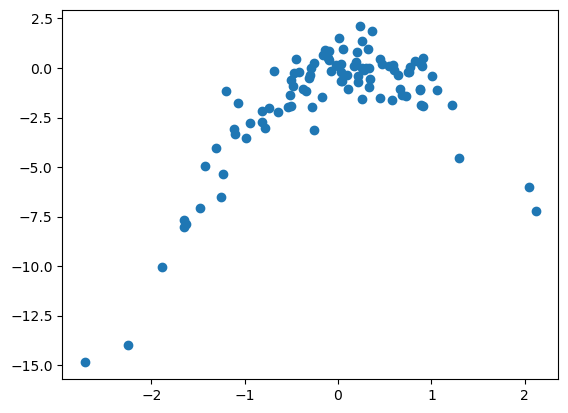

In [188]:
#B
plt.scatter(x, y)

In [189]:
#C
rng = np.random.default_rng(1)
x = rng.normal(size=100)
y = x - 2 * x**2 + rng.normal(size=100)

df = pd.DataFrame({"x": x, "y": y})

def loocv_error(df, degree):
    n = len(df)
    errors = np.zeros(n)

    for i in range(n):
        train = df.drop(i)
        test = df.iloc[i]

        X_train = np.column_stack([train["x"]**d for d in range(1, degree+1)])
        X_test = np.array([test["x"]**d for d in range(1, degree+1)]).reshape(1, -1)

        X_train = np.column_stack([np.ones(len(train)), X_train])
        X_test = np.column_stack([np.ones(1), X_test])

        y_train = train["y"]

        model = sm.OLS(y_train, X_train).fit()
        y_pred = model.predict(X_test)[0]
        errors[i] = (test["y"] - y_pred)**2

    return errors.mean()

loocv_deg1 = loocv_error(df, 1)
loocv_deg2 = loocv_error(df, 2)
loocv_deg3 = loocv_error(df, 3)
loocv_deg4 = loocv_error(df, 4)

loocv_deg1, loocv_deg2, loocv_deg3, loocv_deg4

(6.633029839181983, 1.122936856341969, 1.3017965489358874, 1.3323942694179296)

In [190]:
#D
rng = np.random.default_rng(42)
x = rng.normal(size=100)
y = x - 2 * x**2 + rng.normal(size=100)

df = pd.DataFrame({"x": x, "y": y})

def loocv_error(df, degree):
    n = len(df)
    errors = np.zeros(n)

    for i in range(n):
        train = df.drop(i)
        test = df.iloc[i]

        X_train = np.column_stack([train["x"]**d for d in range(1, degree+1)])
        X_test = np.array([test["x"]**d for d in range(1, degree+1)]).reshape(1, -1)

        X_train = np.column_stack([np.ones(len(train)), X_train])
        X_test = np.column_stack([np.ones(1), X_test])

        y_train = train["y"]

        model = sm.OLS(y_train, X_train).fit()
        y_pred = model.predict(X_test)[0]
        errors[i] = (test["y"] - y_pred)**2

    return errors.mean()

loocv_deg1 = loocv_error(df, 1)
loocv_deg2 = loocv_error(df, 2)
loocv_deg3 = loocv_error(df, 3)
loocv_deg4 = loocv_error(df, 4)

loocv_deg1, loocv_deg2, loocv_deg3, loocv_deg4

(4.2518828656027745,
 0.9639984632709347,
 0.9912711879229292,
 1.0181801043809107)

E)El modelo de **grado 2** fue el que obtuvo el menor error LOOCV, lo cual tiene sentido porque la relación verdadera y = x - 2x^2  es justamente una curva cuadrática. El modelo lineal (grado 1) no logra capturar esa forma y se queda muy limitado, mientras que los modelos de grado 3 y 4 agregan más complejidad de la necesaria y terminan introduciendo ruido en lugar de mejorar. Por eso, el polinomio de grado 2 es el que ofrece la mejor predicción y el menor error en la validación LOOCV.


F)En los cuatro modelos, las pruebas de significancia respaldan lo que ya había sugerido el LOOCV. El modelo lineal logra captar parte de la tendencia, pero no describe bien la forma real de los datos. En el modelo cuadrático, ambos coeficientes resultan claramente significativos, lo cual es lógico porque la relación verdadera es curva. En los modelos de grado 3 y 4, los términos adicionales dejan de ser útiles: no son significativos y solo agregan variación innecesaria. Esto coincide con los resultados del LOOCV, donde el modelo de grado 2 fue el que mejor funcionó y los modelos más complejos no ofrecieron mejoras.


### Problema 9

In [194]:
#A
boston = pd.read_excel("Boston Housing Dataset 1978.xlsx")
mu_hat = boston["MEDV"].mean()
mu_hat

23.750442477876106

In [195]:
#B
import numpy as np
std_error = boston["MEDV"].std(ddof=1) / np.sqrt(len(boston))
std_error

0.3915901080014807

In [196]:
#C
bootstrap_iterations = 1000
n = len(boston)
bootstrap_iterations_array = np.empty((bootstrap_iterations, 1))

for i in range(bootstrap_iterations):
    sample = resample(boston, replace=True, n_samples=n)
    mu_boot = sample["MEDV"].mean()
    bootstrap_iterations_array[i] = mu_boot

mu_bootstrap = bootstrap_iterations_array[:, 0]
bootstrap_se = mu_bootstrap.std(ddof=1)
bootstrap_se

0.40719877716505043

In [197]:
#D
mu_hat = boston["MEDV"].mean()
ci_lower = mu_hat - 2 * bootstrap_se
ci_upper = mu_hat + 2 * bootstrap_se
ci_lower, ci_upper

(22.936044923546007, 24.564840032206206)

In [198]:
#E
mu_hat_med = boston["MEDV"].median()
mu_hat_med

21.95

In [199]:
#F
median_boot_iterations = 1000
n = len(boston)
median_bootstrap_array = np.empty((median_boot_iterations, 1))

for i in range(median_boot_iterations):
    sample = resample(boston, replace=True, n_samples=n)
    median_boot = sample["MEDV"].median()
    median_bootstrap_array[i] = median_boot

median_bootstrap = median_bootstrap_array[:, 0]
median_bootstrap_se = median_bootstrap.std(ddof=1)
median_bootstrap_se

0.30596013073863354

In [200]:
#G
mu_hat_0_1 = np.percentile(boston["MEDV"].dropna(), 10)
mu_hat_0_1

14.5

In [201]:
#H
percentile_boot_iterations = 1000
n = len(boston)
percentile_bootstrap_array = np.empty((percentile_boot_iterations, 1))

for i in range(percentile_boot_iterations):
    sample = resample(boston, replace=True, n_samples=n)
    percentile_boot = np.percentile(sample["MEDV"].dropna(), 10)
    percentile_bootstrap_array[i] = percentile_boot

percentile_bootstrap = percentile_bootstrap_array[:, 0]
percentile_bootstrap_se = percentile_bootstrap.std(ddof=1)
percentile_bootstrap_se

0.4051274112169149

La media, la mediana y el percentil 10 de los precios de las casas resultaron ser estimaciones muy estables. Tanto los errores estándar tradicionales como los obtenidos por bootstrap fueron pequeños, lo que indica que estos valores no cambian mucho de una muestra a otra. Además, el intervalo de confianza para la media sugiere que el precio promedio de una vivienda en el dataset se encuentra aproximadamente entre 22.9 y 24.6 mil dólares.
